Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 2.0032, Test Accuracy: 0.3556
Epoch 2/10, Loss: 1.8739, Test Accuracy: 0.3645
Epoch 3/10, Loss: 1.8358, Test Accuracy: 0.3807
Epoch 4/10, Loss: 1.8145, Test Accuracy: 0.3854
Epoch 5/10, Loss: 1.7997, Test Accuracy: 0.3895
Epoch 6/10, Loss: 1.7879, Test Accuracy: 0.3932
Epoch 7/10, Loss: 1.7788, Test Accuracy: 0.3952
Epoch 8/10, Loss: 1.7709, Test Accuracy: 0.3985
Epoch 9/10, Loss: 1.7639, Test Accuracy: 0.3983
Epoch 10/10, Loss: 1.7580, Test Accuracy: 0.3997


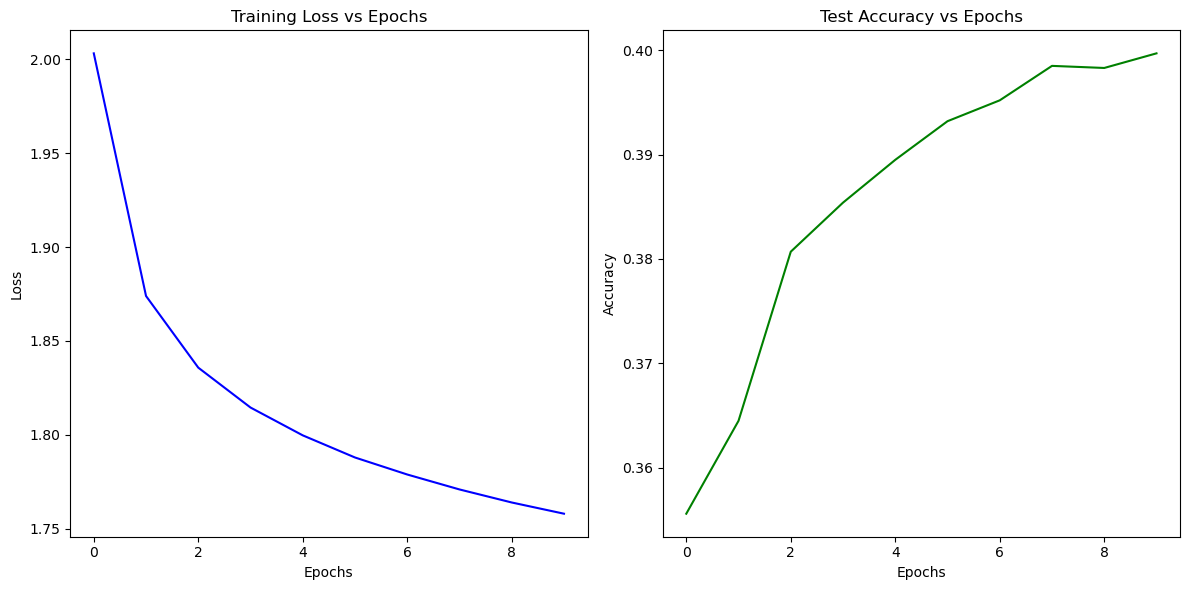

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms  # Fixing the alias name
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Define transformations
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

# Load CIFAR-10 dataset with the correct transform
trainSet = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testSet = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainDataLoader = DataLoader(trainSet, batch_size=64, shuffle=True)
testDataLoader = DataLoader(testSet, batch_size=64, shuffle=False)

# Define the linear classifier model (with L2 regularization)
class LinearClassifier:
    def __init__(self, inputSize, numClasses, lambdaReg=0.0):  # Fixed __init__
        # Initialize model parameters (weights and bias)
        self.Weights = np.random.randn(inputSize, numClasses) * 0.01  # Weight initialization
        self.Bias = np.zeros((1, numClasses))  # Bias initialization
        self.lambdaReg = lambdaReg  # L2 regularization strength (0 for no regularization)
    
    def forward(self, X):
        return np.dot(X, self.Weights) + self.Bias  # Linear forward pass
    
    def LossComputation(self, scoreValues, y):
        numOfSamples = scoreValues.shape[0]
        exp_scores = np.exp(scoreValues - np.max(scoreValues, axis=1, keepdims=True))  # Numerical stability
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        correct_log_probabilities = -np.log(probabilities[np.arange(numOfSamples), y])
        loss = np.sum(correct_log_probabilities) / numOfSamples

        # L2 regularization 
        regularizationLoss = self.lambdaReg * np.sum(self.Weights ** 2)
        loss += regularizationLoss  # Add regularization loss
        return loss, probabilities
    
    def backward(self, X, probabilities, y):
        numOfSamples = X.shape[0]
        dScores = probabilities
        dScores[np.arange(numOfSamples), y] -= 1
        dScores /= numOfSamples
        dWeight = np.dot(X.T, dScores)

        # Add gradient of regularization term
        dWeight += 2 * self.lambdaReg * self.Weights

        db = np.sum(dScores, axis=0, keepdims=True)
        return dWeight, db
    
    def update_parameters(self, dWeight, db, learningRate):
        self.Weights -= learningRate * dWeight  # Update weights
        self.Bias -= learningRate * db  # Update bias

# Hyperparameters
inputSize = 32 * 32 * 3  # CIFAR-10 image size (32x32x3)
numClasses = 10  # CIFAR-10 has 10 classes
learningRate = 0.001
epochs = 10
lambdaReg = 0.001  # Regularization strength

# Initialize model
model = LinearClassifier(inputSize, numClasses, lambdaReg=lambdaReg)

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    model.Weights = model.Weights.astype(np.float32)  # Ensure that model weights are in the correct dtype (float32)

    epochLoss = 0
    for i, (XBatch, YBatch) in enumerate(trainDataLoader):
        XBatch = XBatch.view(XBatch.size(0), -1).numpy()  # Flatten the batch of images
        YBatch = YBatch.numpy()  # Convert labels to numpy array

        # Forward pass
        scoreValues = model.forward(XBatch)

        # Compute loss
        lossValue, probabilities = model.LossComputation(scoreValues, YBatch)
        epochLoss += lossValue

        # Backward pass
        dWeight, dbias = model.backward(XBatch, probabilities, YBatch)

        # Parameter update
        model.update_parameters(dWeight, dbias, learningRate)

    train_losses.append(epochLoss / len(trainDataLoader))  # Average loss for this epoch

    # Evaluate on the test set
    model.Weights = model.Weights.astype(np.float32)  # Ensure model weights are float32 for consistency
    testScores = []
    testLabels = []

    for XBatch, YBatch in testDataLoader:
        XBatch = XBatch.view(XBatch.size(0), -1).numpy()  # Flatten images
        YBatch = YBatch.numpy()  # Convert labels to numpy array

        # Forward pass
        scoreValues = model.forward(XBatch)
        testScores.append(scoreValues)
        testLabels.append(YBatch)
    
    # Concatenate results
    testScores = np.concatenate(testScores, axis=0)
    testLabels = np.concatenate(testLabels, axis=0)

    # Compute accuracy
    predictedLabels = np.argmax(testScores, axis=1)
    accuracyScore = accuracy_score(testLabels, predictedLabels)
    test_accuracies.append(accuracyScore)

    # Print Epoch statistics
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epochLoss / len(trainDataLoader):.4f}, Test Accuracy: {accuracyScore:.4f}")

# Plot Training Loss and Test Accuracy
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Training Loss', color='b')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label='Test Accuracy', color='g')
plt.title('Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()